In [1]:
%cd /content
!rm -rf salient-object-detection


/content


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content
!git clone https://github.com/aidaliu-xpo/salient-object-detection.git
%cd salient-object-detection

/content
Cloning into 'salient-object-detection'...
remote: Enumerating objects: 68346, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 68346 (delta 13), reused 17 (delta 8), pack-reused 68320 (from 2)
Receiving objects: 100% (68346/68346), 654.34 MiB | 21.08 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/salient-object-detection


In [4]:
%cd /content/salient-object-detection

/content/salient-object-detection


In [5]:
!unzip -q /content/drive/MyDrive/datasets/DUTS.zip -d /content/salient-object-detection/data


In [6]:
!python data_loader.py

In [7]:
!python sod_model.py

In [8]:
!python train.py

Using device: cuda
Epoch 1/40 - Train Loss: 0.8109
           Validation Loss: 0.7325
           ✔ Saved best model
Epoch 2/40 - Train Loss: 0.6836
           Validation Loss: 0.6825
           ✔ Saved best model
Epoch 3/40 - Train Loss: 0.6413
           Validation Loss: 0.6463
           ✔ Saved best model
Epoch 4/40 - Train Loss: 0.6122
           Validation Loss: 0.5957
           ✔ Saved best model
Epoch 5/40 - Train Loss: 0.5903
           Validation Loss: 0.5866
           ✔ Saved best model
Epoch 6/40 - Train Loss: 0.5716
           Validation Loss: 0.5653
           ✔ Saved best model
Epoch 7/40 - Train Loss: 0.5592
           Validation Loss: 0.5788
Epoch 8/40 - Train Loss: 0.5464
           Validation Loss: 0.5495
           ✔ Saved best model
Epoch 9/40 - Train Loss: 0.5344
           Validation Loss: 0.5358
           ✔ Saved best model
Epoch 10/40 - Train Loss: 0.5234
           Validation Loss: 0.5163
           ✔ Saved best model
Epoch 11/40 - Train Loss: 0.5168
       

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset

from sod_model import SaliencyNet
from data_loader import SaliencyDataset, Augment

# same paths as in train.py
images_dir = 'data/DUTS/resized_images_224'
masks_dir  = 'data/DUTS/resized_masks_224'

# rebuild dataset + split exactly like in train.py
SEED = 31
np.random.seed(SEED)
import random
random.seed(SEED)
torch.manual_seed(SEED)

base_dataset = SaliencyDataset(images_dir, masks_dir, transform=None)
N = len(base_dataset)

indexes = list(range(N))
random.shuffle(indexes)

train_end = int(0.7 * N)
val_end   = int(0.85 * N)

train_ids = indexes[:train_end]
val_ids   = indexes[train_end:val_end]
test_ids  = indexes[val_end:]

eval_dataset_full = SaliencyDataset(images_dir, masks_dir, transform=None)
test_dataset = Subset(eval_dataset_full, test_ids)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SaliencyNet().to(device)
model.load_state_dict(torch.load('best_sod_model.pth', map_location=device))
model.eval()


SaliencyNet(
  (enc1): ConvBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): ConvBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): ConvBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), pa

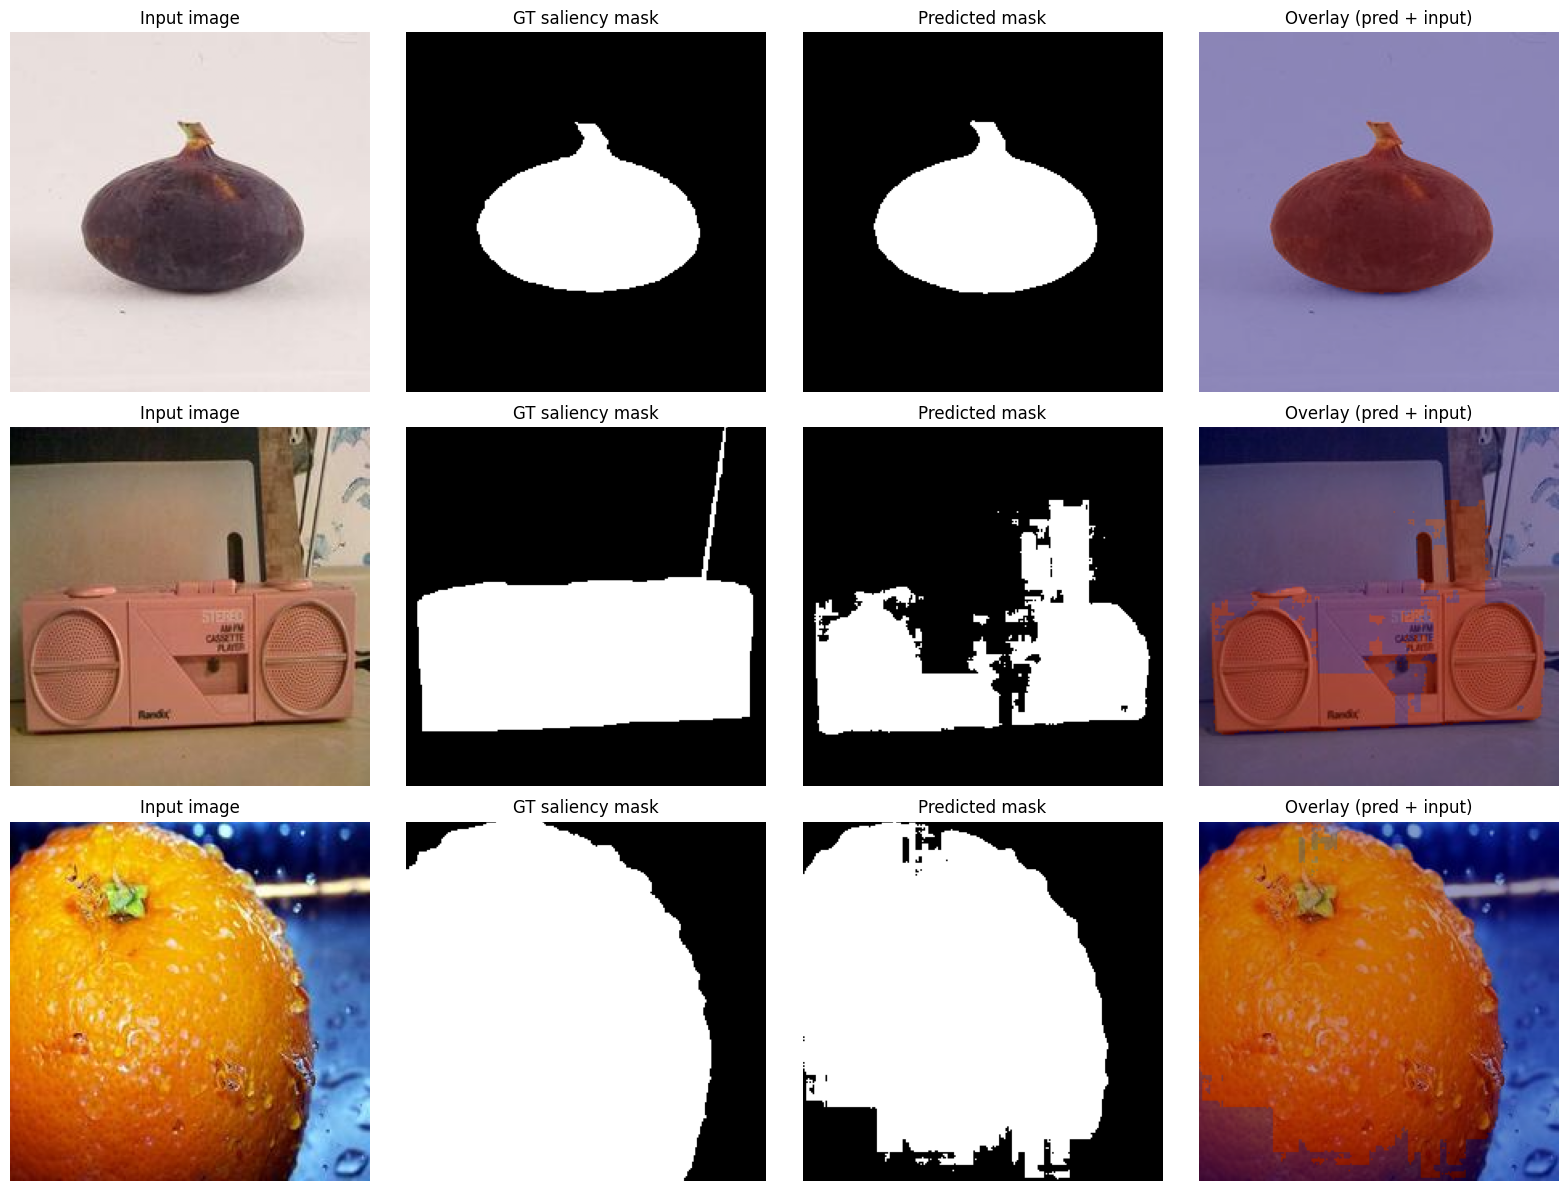

In [10]:
# -----------------------------
# VISUALIZATION (ON BEST MODEL)
# -----------------------------
images, masks = next(iter(test_loader))
images = images.to(device)
masks  = masks.to(device)

with torch.no_grad():
    preds = model(images)  # (B, 1, H, W)

images_cpu = images.cpu()
masks_cpu  = masks.cpu()
preds_cpu  = preds.cpu()

bin_preds = (preds_cpu > 0.5).float()

num_show = min(3, images_cpu.size(0))

plt.figure(figsize=(16, 4 * num_show))

for i in range(num_show):
    img  = images_cpu[i].permute(1, 2, 0)
    gt   = masks_cpu[i].squeeze()
    pred = bin_preds[i].squeeze()

    plt.subplot(num_show, 4, 4*i + 1)
    plt.title("Input image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(num_show, 4, 4*i + 2)
    plt.title("GT saliency mask")
    plt.imshow(gt, cmap="gray")
    plt.axis("off")

    plt.subplot(num_show, 4, 4*i + 3)
    plt.title("Predicted mask")
    plt.imshow(pred, cmap="gray")
    plt.axis("off")

    plt.subplot(num_show, 4, 4*i + 4)
    plt.title("Overlay (pred + input)")
    plt.imshow(img)
    plt.imshow(pred, cmap="jet", alpha=0.4)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [13]:
!cp /content/salient-object-detection/best_sod_model.pth \
  "/content/drive/MyDrive/best_sod_model.pth"
